# Get the data

In [ ]:
! pip install -U torchvision torch

Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.7.0+cu101)
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)


In [ ]:
#  https://www.kaggle.com/huanghanchina/pascal-voc-2012   download the dataset from here

# https://github.com/MIVRC/MSRN-PyTorch/tree/master/OLD

In [1]:
! wget "https://storage.googleapis.com/kaggle-data-sets/35388%2F47853%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599818417&Signature=l2IBA3KGkH0gw6gyPoEbSaRP%2Fe3x5dHWFWHDoV%2BJ0nQ2IAOQ8w3Ph7uEbeGSxDj6ujF%2FIqXbQ0G8n%2FX68A%2FiZ1KaOAUSD7AMl8azCWF5kwLxzDDwKDx1PoLBRArkfWd4TixkjHaukFyjvQFZYodb3LGw3USSsrFE0IpkRR66zfWahZVVCR4CYtiIWSQI1FSCPu5eRhIfbYq2vsc7U9HyzC8DbRpSy%2FuZPqAvc72IwPdUqGRbJHV520WkHc2Ind4q%2FJs15DEuCA33m8igtXCJ9fr2qIVdzmesoORLySWfRZFPdZ4SUG6CcqENsW5VOxBqsuPL43BRGBlmSavWbVv8ZQ%3D%3D" -O VOC2012.zip

--2020-09-09 03:25:55--  https://storage.googleapis.com/kaggle-data-sets/35388%2F47853%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599818417&Signature=l2IBA3KGkH0gw6gyPoEbSaRP%2Fe3x5dHWFWHDoV%2BJ0nQ2IAOQ8w3Ph7uEbeGSxDj6ujF%2FIqXbQ0G8n%2FX68A%2FiZ1KaOAUSD7AMl8azCWF5kwLxzDDwKDx1PoLBRArkfWd4TixkjHaukFyjvQFZYodb3LGw3USSsrFE0IpkRR66zfWahZVVCR4CYtiIWSQI1FSCPu5eRhIfbYq2vsc7U9HyzC8DbRpSy%2FuZPqAvc72IwPdUqGRbJHV520WkHc2Ind4q%2FJs15DEuCA33m8igtXCJ9fr2qIVdzmesoORLySWfRZFPdZ4SUG6CcqENsW5VOxBqsuPL43BRGBlmSavWbVv8ZQ%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3899239928 (3.6G) [application/zip]
Saving to: ‘VOC2012.zip’

VOC2012.zip         100%[===================>]   3.63G  48.4MB/s    in 74s     

2020-09-09 03:27:10 (

In [2]:
! unzip -qq VOC2012.zip

# Split the dataset

In [3]:
! mkdir VALIDATION
! mkdir statistics

In [4]:
# make this directory, for storing in small values of epochs
! mkdir epochs

In [5]:
import glob
import shutil
from tqdm import tqdm
img_files = glob.glob('VOC2012/JPEGImages/*')
#print(len(img_files))

Val_split = int(0.01 * len(img_files))
Val_split

171

In [6]:
for item in tqdm(img_files[0:Val_split]):
  shutil.move(item,"VALIDATION")

100%|██████████| 171/171 [00:00<00:00, 24845.02it/s]


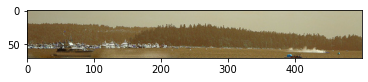

In [7]:
import matplotlib.pyplot as plt
import cv2
im = cv2.imread('VOC2012/JPEGImages/2008_001823.jpg')
plt.imshow(im)

# Clean the dataset

In [8]:
! rm "VOC2012/JPEGImages/2008_001823.jpg"

In [9]:
import glob
val_files = glob.glob('VALIDATION/*')
print(len(val_files))

171


# Check the images : PASCAL VOC

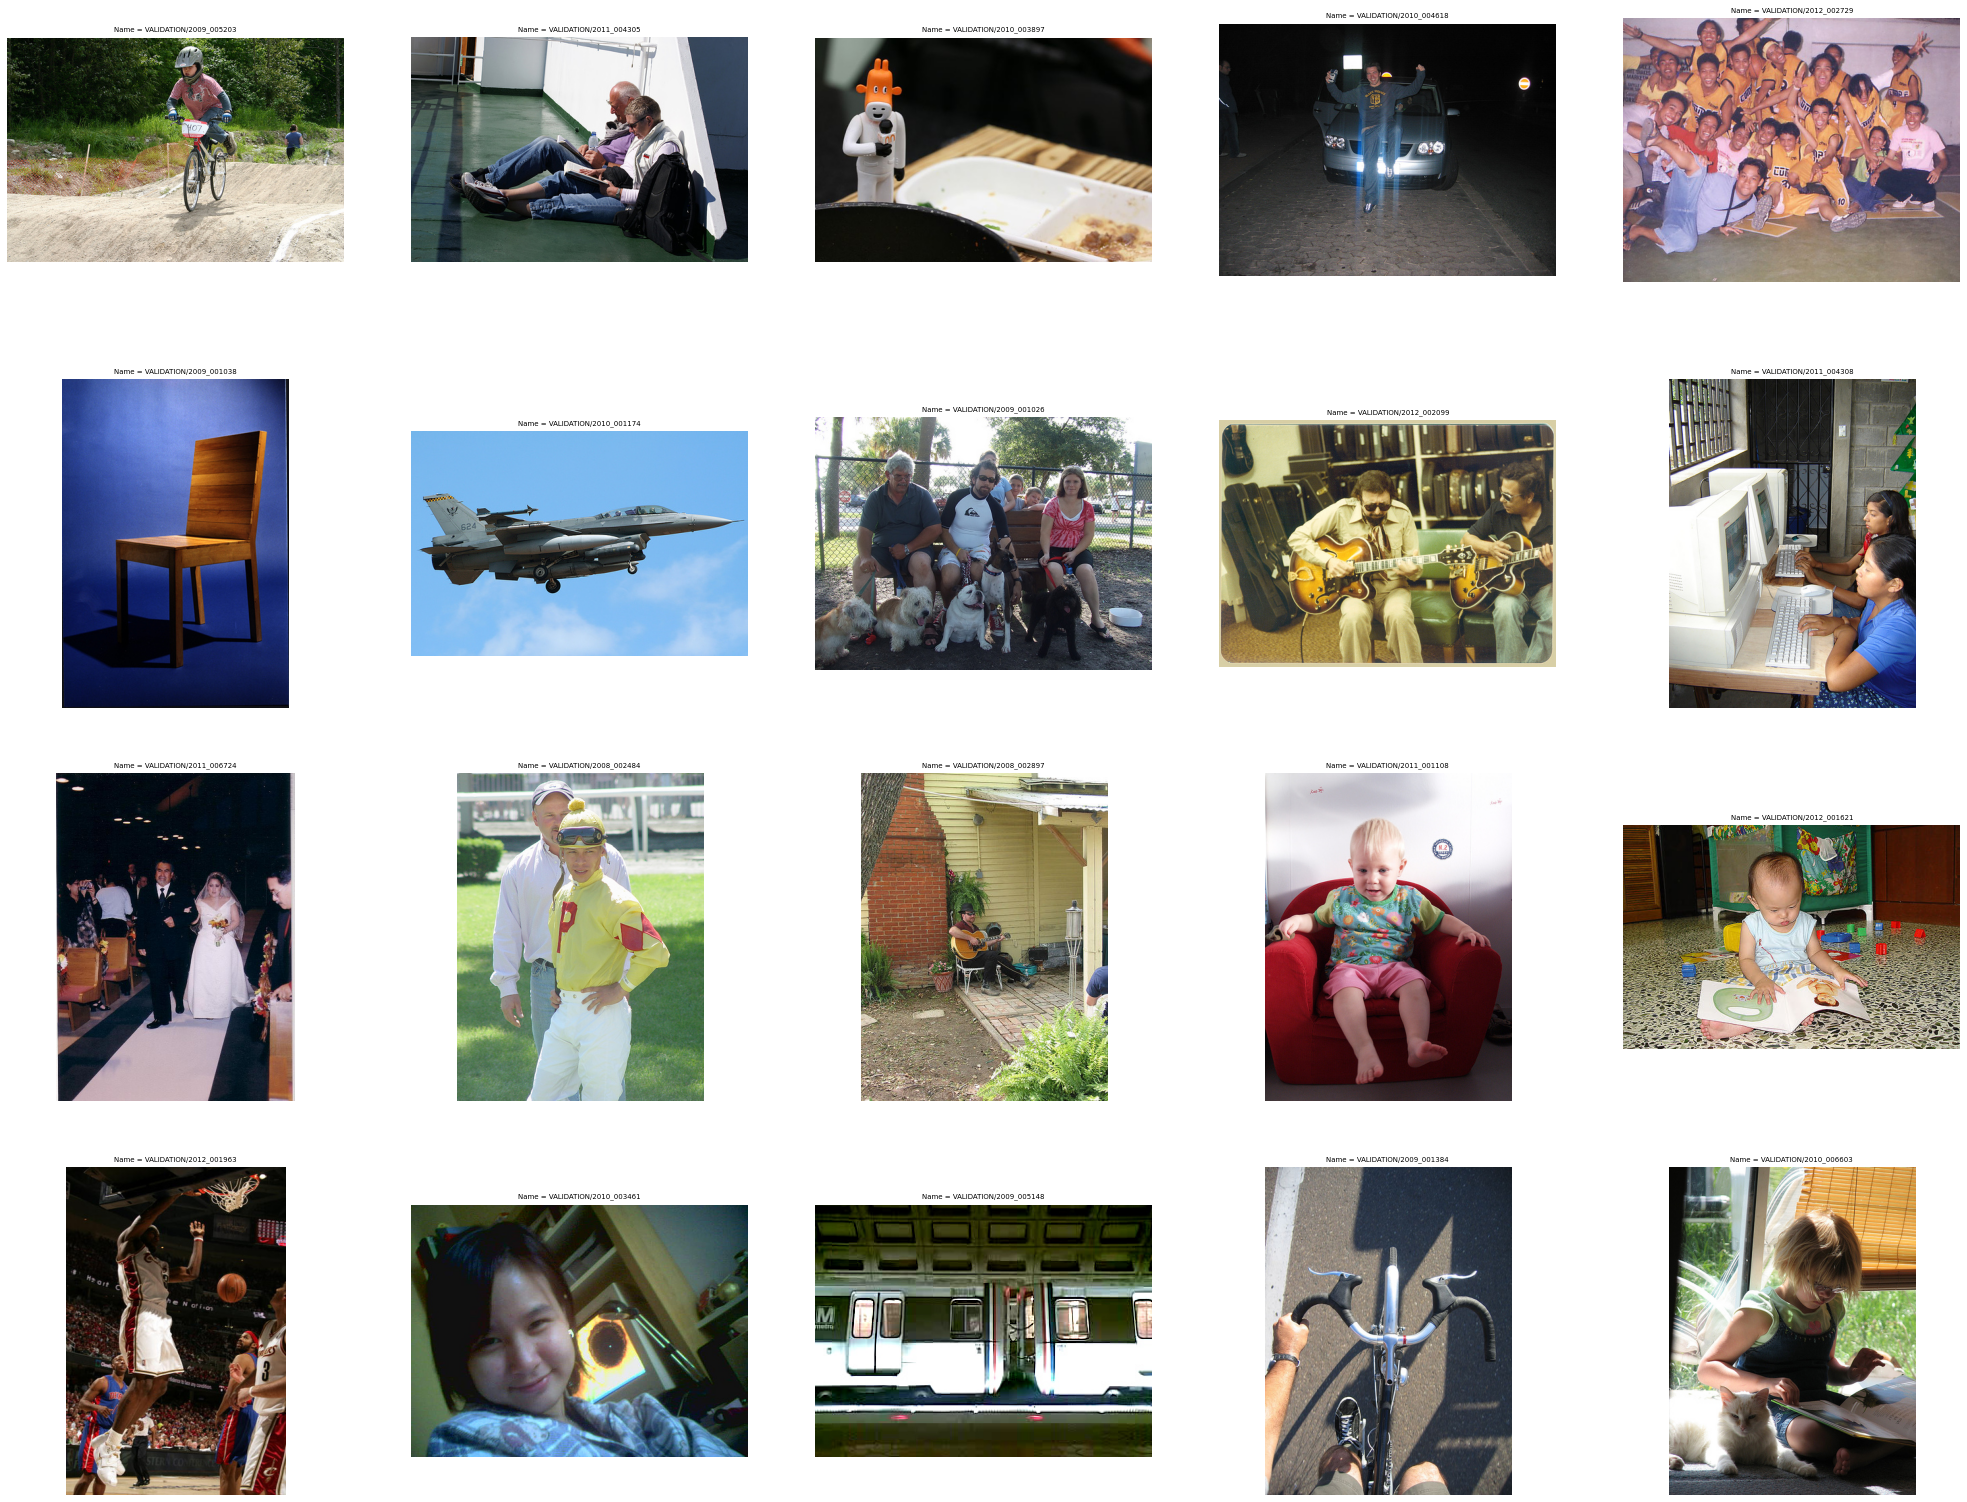

In [10]:
import matplotlib.pyplot as plt
import cv2

total_img = 20
num_pr = 5 # number per row

counter = 1
plt.figure(figsize=(35,35))
plt.axis('off')
for item in val_files[:total_img]:
  image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  plt.subplot(num_pr, num_pr, counter)
  plt.title("Name = {}".format(str(item.split('.')[0])),fontsize=7).set_color('black')
  plt.axis('off')
  plt.imshow(image[:,:,::-1])
  counter += 1
  #break
plt.show()

# data_utils.py

In [11]:
from os import listdir
from os.path import join

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        try:
            hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
            
            lr_image = self.lr_transform(hr_image)
            return lr_image, hr_image
        except:
            print("image = ", self.image_filenames[index], "index = ", index)

    def __len__(self):
        return len(self.image_filenames)


class ValDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(ValDatasetFromFolder, self).__init__()
        self.upscale_factor = upscale_factor
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])
        w, h = hr_image.size
        crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_filenames)


class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(TestDatasetFromFolder, self).__init__()
        self.lr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/data/'
        self.hr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/target/'
        self.upscale_factor = upscale_factor
        self.lr_filenames = [join(self.lr_path, x) for x in listdir(self.lr_path) if is_image_file(x)]
        self.hr_filenames = [join(self.hr_path, x) for x in listdir(self.hr_path) if is_image_file(x)]

    def __getitem__(self, index):
        image_name = self.lr_filenames[index].split('/')[-1]
        lr_image = Image.open(self.lr_filenames[index])
        w, h = lr_image.size
        hr_image = Image.open(self.hr_filenames[index])
        hr_scale = Resize((self.upscale_factor * h, self.upscale_factor * w), interpolation=Image.BICUBIC)
        hr_restore_img = hr_scale(lr_image)
        return image_name, ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.lr_filenames)

In [12]:
# https://github.com/leftthomas/SRGAN/blob/master/model.py

# model.py

In [13]:
import math
import torch
from torch import nn


class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

# loss.py

In [14]:
import torch
from torch import nn
from torchvision.models.vgg import vgg16


class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


if __name__ == "__main__":
    g_loss = GeneratorLoss()
    print(g_loss)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



GeneratorLoss(
  (loss_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

# pytorch_ssim.py

In [15]:
from math import exp

import torch
import torch.nn.functional as F
from torch.autograd import Variable


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

# train.py

In [ ]:
import argparse
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

# import pytorch_ssim
# from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
# from loss import GeneratorLoss
# from model import Generator, Discriminator

# parser = argparse.ArgumentParser(description='Train Super Resolution Models')
# parser.add_argument('--crop_size', default=88, type=int, help='training images crop size')
# parser.add_argument('--upscale_factor', default=4, type=int, choices=[2, 4, 8],
#                     help='super resolution upscale factor')
# parser.add_argument('--num_epochs', default=100, type=int, help='train epoch number')




crop_size = 88
upscale_factor = 4
num_epochs = 3


if __name__ == '__main__':
    #opt = parser.parse_args()
    
    CROP_SIZE = crop_size
    UPSCALE_FACTOR = upscale_factor
    NUM_EPOCHS = num_epochs
    
    train_set = TrainDatasetFromFolder('VOC2012/JPEGImages', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
    val_set = ValDatasetFromFolder('VALIDATION', upscale_factor=UPSCALE_FACTOR)
    train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=1, shuffle=False)
    
    netG = Generator(UPSCALE_FACTOR)
    print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
    netD = Discriminator()
    print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))
    
    generator_criterion = GeneratorLoss()
    
    if torch.cuda.is_available():
        netG.cuda()
        netD.cuda()
        generator_criterion.cuda()
    
    optimizerG = optim.Adam(netG.parameters())
    optimizerD = optim.Adam(netD.parameters())
    
    results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}
    
    for epoch in range(1, NUM_EPOCHS + 1):
        train_bar = train_loader #tqdm(train_loader)
        
          
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
    
        netG.train()
        netD.train()
        epochs_counter = 0
        #try:
          # try block some error?
          # a dirty solution else error at 55% 

        for data, target in train_bar:
            g_update_first = True
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size
    
            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target)
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)
            if torch.cuda.is_available():
                z = z.cuda()
            fake_img = netG(z)
    
            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            optimizerD.step()
    
            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            netG.zero_grad()
            ############################################################
            ## The two lines below are added to prevent runetime error! ##
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            ############################################################
            g_loss = generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()
            
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
              
            optimizerG.step()

            # loss for current batch before optimization 
            running_results['g_loss'] += g_loss.item() * batch_size
            running_results['d_loss'] += d_loss.item() * batch_size
            running_results['d_score'] += real_out.item() * batch_size
            running_results['g_score'] += fake_out.item() * batch_size
            epochs_counter += 1
            if epochs_counter % 20 == 0:
              print("[{}/{}/{}] Loss_D: {} Loss_G: {} D(x): {} D(G(z)): {}".format(epochs_counter, 
                    epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
                    running_results['g_loss'] / running_results['batch_sizes'],
                    running_results['d_score'] / running_results['batch_sizes'],
                    running_results['g_score'] / running_results['batch_sizes']))
              
            # train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            #     epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            #     running_results['g_loss'] / running_results['batch_sizes'],
            #     running_results['d_score'] / running_results['batch_sizes'],
            #     running_results['g_score'] / running_results['batch_sizes']))
    
        netG.eval()
        out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        val_epochs_counter = 0
        with torch.no_grad():
            val_bar = val_loader
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = val_lr
                hr = val_hr
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = netG(lr)
                val_epochs_counter += 1
                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size
                batch_ssim = ssim(sr, hr).item()
                valing_results['ssims'] += batch_ssim * batch_size
                valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
                valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
                if val_epochs_counter % 100 == 0:
                    print("[converting LR images to SR images] PSNR: {} dB SSIM: {}".format(
                        valing_results['psnr'], valing_results['ssim']))
                
                # val_bar.set_description(
                #     desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                #         valing_results['psnr'], valing_results['ssim']))
                
                val_images.extend(
                    [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                    display_transform()(sr.data.cpu().squeeze(0))])
                
            val_images = torch.stack(val_images)
            val_images = torch.chunk(val_images, val_images.size(0) // 15)
            val_save_bar = tqdm(val_images, desc='[saving training results]')
            index = 1
            for image in val_save_bar:
                image = utils.make_grid(image, nrow=3, padding=5)
                utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
                index += 1
          
        # except:
        #   print("data = ",data," target = ",target)
        #   break
          #print("Some error, continuing!")
          #continue
        # save model parameters
        torch.save(netG.state_dict(), 'epochs/netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
        torch.save(netD.state_dict(), 'epochs/netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
        # save loss\scores\psnr\ssim
        results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        results['psnr'].append(valing_results['psnr'])
        results['ssim'].append(valing_results['ssim'])
    
        if epoch % 10 == 0 and epoch != 0:
            out_path = 'statistics/'
            data_frame = pd.DataFrame(
                data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                      'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
                index=range(1, epoch + 1))
            data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')


# generator parameters: 734219
# discriminator parameters: 5215425
[20/1/3] Loss_D: 0.7210472598671913 Loss_G: 0.03377520553767681 D(x): 0.561209213733673 D(G(z)): 0.2564747265540063
[40/1/3] Loss_D: 0.8588438190519809 Loss_G: 0.027507249731570482 D(x): 0.5728703439235687 D(G(z)): 0.41600351887755094
[60/1/3] Loss_D: 0.9036190961798032 Loss_G: 0.02434161229369541 D(x): 0.5777644425630569 D(G(z)): 0.4705380327689151
[80/1/3] Loss_D: 0.9259663488715887 Loss_G: 0.022184666094835846 D(x): 0.601024616509676 D(G(z)): 0.5190342774381861
[100/1/3] Loss_D: 0.9414537701010705 Loss_G: 0.020579311707988383 D(x): 0.6090959203243256 D(G(z)): 0.5438607339374721
[120/1/3] Loss_D: 0.951065257936716 Loss_G: 0.019540075554202 D(x): 0.6133505995074908 D(G(z)): 0.5584672106895596
[140/1/3] Loss_D: 0.9580715424248151 Loss_G: 0.01866599466385586 D(x): 0.6053503372839519 D(G(z)): 0.5577847988344729
[160/1/3] Loss_D: 0.9634223436936736 Loss_G: 0.018027025228366255 D(x): 0.61311343498528 D(G(z)): 0.572491616464

[saving training results]: 100%|██████████| 33/33 [00:34<00:00,  1.06s/it]


[20/2/3] Loss_D: 1.0006803125143051 Loss_G: 0.010453579807654023 D(x): 0.5401833847165107 D(G(z)): 0.5390324115753173


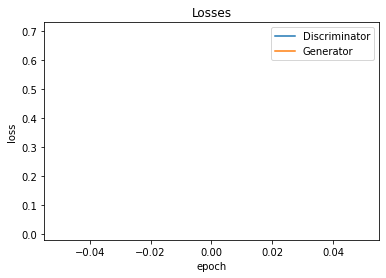

In [20]:
plt.plot(results['d_loss'], '-')
plt.plot(results['g_loss'], '-')

plt.plot(results['d_score'], '-')
plt.plot(results['g_score'], '-')
plt.plot(results['psnr'], '-')
plt.plot(results['ssim'], '-')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['Discriminator', 'Generator', 'Discriminator score', 'Generator score', 'PSNR', 'SSIM'])
plt.title('Losses');




In [ ]:
plt.plot(results['d_loss'], '-')
plt.plot(results['g_loss'], '-')


plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');


In [ ]:
plt.plot(results['d_score'], '-')
plt.plot(results['g_score'], '-')

plt.xlabel('time')
plt.ylabel('value')

plt.legend(['Discriminator score', 'Generator score'])
plt.title('Scores');


In [ ]:
plt.plot(results['psnr'], '-')
plt.plot(results['ssim'], '-')

plt.xlabel('time')
plt.ylabel('value')

plt.legend(['PSNR', 'SSIM'])
plt.title('Ratios');
